## Flood Impact Prediction (FIP) Assessment
The description would be updated...

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from shapely.geometry import Point
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, QuantileTransformer
import matplotlib.pyplot as plt
from functools import reduce
import fhv
# pd.options.mode.chained_assignment = None
import matplotlib as mpl
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from pyproj import Proj, transform    # In case of re-projection
lims = [88.00, 92.7, 20.57, 26.64]    # [xmin, xmax, ymin, ymax]

### Load basic data

In [2]:
# Union ID list (5160)
uidList = pd.read_hdf('./data/uidlist.hdf')
# Flatten cell indices for Union ID
uidx = np.load('./data/uidx.npz', allow_pickle=True)['uidx']
# Shapefiles of administrative units
shp_district = gpd.read_file('./data/adm_district.shp')
shp_upazila = gpd.read_file('./data/adm_upazila.shp')
shp_union = gpd.read_file('./data/adm_union.shp')

### Number of people affected by 2017 flood
The affected people is assessed by counting population per pixel (PPP) in the flooded areas.
- Valid cells per each Union is pre-processed

In [3]:
# Load data
inun = rasterio.open('./data/bgd_inun_30m.tif').read(1).flatten()              # 1 (Perennial waterbodies), 2 (Flood inundation area)
popu = rasterio.open('./data/bgd_ppp_2017_30m_decuple.tif').read(1).flatten()  # Population Per Pixel (Decuple value)
fcst = rasterio.open('./data/flood2017forecast_30m_aug16_ffwc_decuple.tif').read(1).flatten()  # Flood depth (decuple)

In [4]:
# Affected population by Flood Inundation and Flood Forecast
# - Flood Inundation
popuInun = popu.copy()
popuInun[inun == 0] = 0       # Population in both Perennial water and Flood inundation
popuInun[inun != 2] = 0       # Population in Flood inundation
# - Flood Forecast
popuFcst = popu.copy()
popuFcst[fcst < 30] = 0       # Population in Flood depth (>= 1.0m)

# Counting population
totlPopu = np.zeros(uidList.shape)
afftPopuInun = np.zeros_like(totlPopu)
afftPopuFcst = np.zeros_like(totlPopu)
totlCell = [len(udx) for udx in uidx]
afftCellInun = np.zeros_like(totlPopu)
afftCellFcst = np.zeros_like(totlPopu)
for i, uid in uidList.iteritems():
    totlPopu[i] = popu[uidx[i]].sum()
    afftPopuInun[i] = popuInun[uidx[i]].sum()
    afftPopuFcst[i] = popuFcst[uidx[i]].sum()
    afftCellInun[i] = np.isin(inun[uidx[i]], [1,2]).sum()
    afftCellFcst[i] = np.isin(fcst[uidx[i]], [1]).sum()

# Rescale from decuple to normal and Add one to avoid numeric errors
totlPopu = (totlPopu+1)/10
afftPopuInun /= 10
afftPopuFcst /= 10

In [5]:
# Generate a Union dataframe
impact4 = shp_union.drop('geometry', axis=1)
impact4['POPU_TOTAL'], impact4['POPU_INUN'], impact4['POPU_FCST'] = totlPopu, afftPopuInun, afftPopuFcst
impact4['POPU_INUN_RATIO'] = afftPopuInun/totlPopu
impact4['POPU_FCST_RATIO'] = afftPopuFcst/totlPopu
impact4['CELL_TOTAL'], impact4['CELL_INUN'], impact4['CELL_FCST'] = totlCell, afftCellInun, afftCellFcst
impact4['CELL_INUN_RATIO'] = afftCellInun/totlCell
impact4['CELL_FCST_RATIO'] = afftCellFcst/totlCell
# Aggregate to Upazila level
varlist = ['POPU_TOTAL','POPU_INUN','POPU_FCST','CELL_TOTAL','CELL_INUN','CELL_FCST']
impact3 = impact4.groupby(['ADM3_PCODE', 'ADM3_EN'])[varlist].sum()
impact3['POPU_INUN_RATIO'] = impact3['POPU_INUN']/impact3['POPU_TOTAL']
impact3['POPU_FCST_RATIO'] = impact3['POPU_FCST']/impact3['POPU_TOTAL']
impact3['CELL_INUN_RATIO'] = impact3['CELL_INUN']/impact3['CELL_TOTAL']
impact3['CELL_FCST_RATIO'] = impact3['CELL_FCST']/impact3['CELL_TOTAL']
impact3['ADM2_PCODE'], impact3['ADM2_EN'] = shp_upazila['ADM2_PCODE'].values, shp_upazila['ADM2_EN'].values
# Aggregate to District level
impact2 = impact3.groupby(['ADM2_PCODE', 'ADM2_EN'])[varlist].sum()
impact2['POPU_INUN_RATIO'] = impact2['POPU_INUN']/impact2['POPU_TOTAL']
impact2['POPU_FCST_RATIO'] = impact2['POPU_FCST']/impact2['POPU_TOTAL']
impact2['CELL_INUN_RATIO'] = impact2['CELL_INUN']/impact2['CELL_TOTAL']
impact2['CELL_FCST_RATIO'] = impact2['CELL_FCST']/impact2['CELL_TOTAL']
impact2['ADM1_PCODE'], impact2['ADM1_EN'] = shp_district['ADM1_PCODE'].values, shp_district['ADM1_EN'].values

# Print
print('TOTAL_POPU_INUN: {:,}'.format(impact4['POPU_INUN'].sum().astype(int)))
print('TOTAL_POPU_FCST: {:,}'.format(impact4['POPU_FCST'].sum().astype(int)))

# Merge with shapefiles
varlist.extend(['POPU_INUN_RATIO', 'POPU_FCST_RATIO', 'CELL_INUN_RATIO', 'CELL_FCST_RATIO'])
map_union = shp_union.merge(impact4, on='ADM4_PCODE')
map_upazila = shp_upazila.merge(impact3[varlist], on='ADM3_PCODE')
map_district = shp_district.merge(impact2[varlist], on='ADM2_PCODE')

TOTAL_POPU_INUN: 19,642,620
TOTAL_POPU_FCST: 10,063,213


### Mapping Percentage of Affected Population

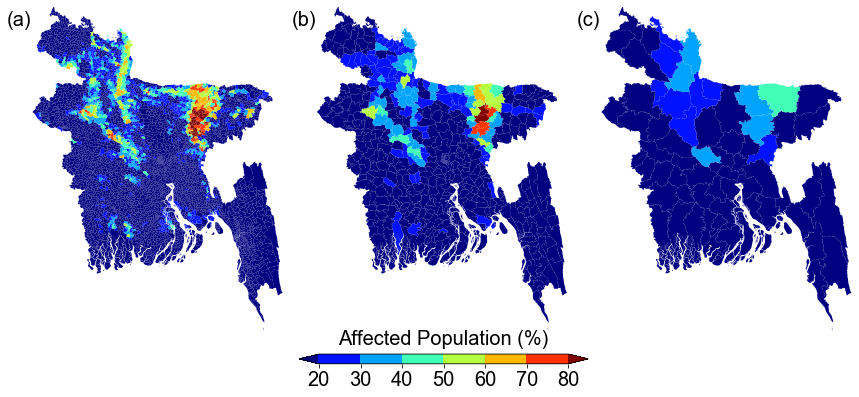

In [7]:
# Mapping
# sns.set_style("white", {'axes.linewidth': 1, 'grid.color': 'black'})

# Colormap
bounds = list(np.arange(0.2,0.8,0.1))
boundaries = [0]+bounds+[1]
cmap, norm, vmin, vmax, ticks, boundaries = fhv.cbarpam(bounds, 'jet', labloc='on',
                                                        boundaries=boundaries, extension='both')

# Plotting
fignumb = ['(a)', '(b)', '(c)']
figlabel = 'Affected Population (%)'
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(12,5), facecolor='w')
for (i, el) in enumerate([map_union, map_upazila, map_district]):
    ax = axes.flatten('F')[i]
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.axis(lims)
    el.plot(ax=ax, column='POPU_INUN_RATIO', 
            cmap=cmap, norm=norm, vmin=vmin, vmax=vmax)
    ax.annotate(fignumb[i], xy=(-0.05, 0.96), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center',
                fontname='arial',fontsize=20)    
plt.tight_layout()
# Colorbar
cax = inset_axes(ax, width="46%", height="3%",
                 loc='lower left',
                 bbox_to_anchor=(-1.2, -0.1, 2.5, 1),
                 bbox_transform=ax.transAxes,borderpad=0)
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm,
                                 boundaries=boundaries,
                                 extend='both',
                                 extendfrac=0.08,
                                 ticks = ticks,
                                 spacing='uniform',
                                 orientation='horizontal')
cbar.ax.set_xticklabels(['%d'%lb for lb in np.array(bounds)*100], 
                        fontname='arial', fontsize=20)
cbar.set_label(figlabel, labelpad=-60, 
               fontname='arial', fontsize=20, 
               horizontalalignment='center')
plt.show()

In [18]:
impact2.shape

(64, 12)

In [38]:
# 2017 Flood Post-disaster records
record = pd.read_excel('./data/disaster_records/damagedata_20170903_english.xlsx', 
                       header=1, index_col=0, skipfooter=1).fillna(0)
# record.sum()
record

,Name of affected Districts,No of affected Upazila,No of affected Municipality,No of affected unions,No of affected Village,No of fully affecetd Families,No of partially affecetd Families,No of Total affecetd Families,No of Fully damaged Houses,No of partially damaged Houses,No of Total damaged Houses,No of Fully damaged Crops land (Hect),No of partially damaged Crops land (Hect),No of Total damaged Crops land (Hect),No of Death People,No of present temporary Shelter,No of people currently living in temporary Shelter,No of Damaged Water point (Tube well)
SL,,,,,,,,,,,,,,,,,,
1,Panchagarh,5,3,43,0.0,0,45305,45305,0.0,0.0,0,0.0,3907.0,3907,0,0.0,0.0,0
2,Thakurgaon,5,3,44,200.0,0,28800,28800,500.0,2000.0,2500,0.0,8130.0,8130,1,0.0,0.0,527
3,Dinajpur,13,8,86,637.0,46404,101331,147735,21146.0,26101.0,47247,0.0,121170.0,121170,30,0.0,0.0,2163
4,Nilphamari,6,1,51,158.0,301,41234,41535,301.0,23517.0,23818,8715.0,4180.0,12895,6,0.0,0.0,1084
5,Lalmonirhat,5,2,35,510.0,0,102750,102750,1322.0,9169.0,10491,0.0,31400.0,31400,6,1.0,40.0,8630
6,Kurigram,9,2,62,724.0,0,126616,126616,26160.0,88969.0,115129,0.0,50031.0,50031,23,0.0,0.0,12719
7,Rangpur,9,3,61,502.0,0,99621,99621,0.0,0.0,0,0.0,38815.0,38815,6,0.0,0.0,1815
8,Naogaon,11,1,72,594.0,0,98793,98793,27290.0,66350.0,93640,0.0,75836.0,75836,7,44.0,4916.0,0
9,Natore,3,2,17,167.0,1120,15802,16922,1120.0,15552.0,16672,9724.0,3386.0,13110,1,27.0,4290.0,750
